In [1]:
import requests
import pandas as pd
import numpy as np
import json
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from datetime import datetime

# Data Extraction

## Requesting Data from Open Data Philly

The property characteristic and assessment history data in this analysis is sourced from [OpenDataPhilly]([https://opendataphilly.org/datasets/philadelphia-properties-and-assessment-history/), an online repository providing access to data about the Philadelphia region. The data is maintained by the City of Philadelhia's the Office of Property Assessment and contains records for all properties in Philadelphia.

The Property and Property Assessment datasets published to Carto and available to query via [SQL API](https://phl.carto.com/api/v2/sql) using PostgreSQL.
- **Property table**: opa_properties_public
- **Property Assessment table**: assessments

In [2]:
def requestOpenDataPhilly(query: str):
    '''
    Sends request to Open Data Philly's SQL API, and returns the results as a Pandas dataframe

    Args:
        query (str): query written in PostgreSQL

    Return:
        dataframe containing the results of the query
    '''
    print('Sending request to Open Data Philly API.')
    url = 'https://phl.carto.com/api/v2/sql'
    params = {'q':query}

    # send request
    response = requests.get(url, params=params)
    print(f"Open Data API Status Code: {response.status_code}")
    
    # sleep
    time.sleep(2)
    
    try:
        # convert response to df
        response_data = json.loads(str(response.text))                          
        data = response_data['rows']        
        print(f'Returning df for query: {query}.\n')                                    
        return pd.DataFrame.from_dict(data) 
    except:
        return pd.DataFrame() 




In [3]:
# establish queries
prop_query = "SELECT * FROM opa_properties_public" 
assess_2025 = "SELECT * FROM assessments WHERE year = '2025'"
assess_2024 = "SELECT * FROM assessments WHERE year = '2024'"
assess_2023 = "SELECT * FROM assessments WHERE year = '2023'"
assess_2022 = "SELECT * FROM assessments WHERE year = '2022'"
assess_2021 = "SELECT * FROM assessments WHERE year = '2021'"
assess_2020 = "SELECT * FROM assessments WHERE year = '2020'"
assess_2019 = "SELECT * FROM assessments WHERE year = '2019'"
assess_2018 = "SELECT * FROM assessments WHERE year = '2018'"
assess_2017 = "SELECT * FROM assessments WHERE year = '2017'"
assess_2016 = "SELECT * FROM assessments WHERE year = '2016'"
assess_2015 = "SELECT * FROM assessments WHERE year = '2015'"

In [4]:
# # get requests
# prop = requestOpenDataPhilly(prop_query)
# assess_2025 = requestOpenDataPhilly(assess_2025)
# assess_2024 = requestOpenDataPhilly(assess_2024)
# assess_2023 = requestOpenDataPhilly(assess_2023)
# assess_2022 = requestOpenDataPhilly(assess_2022)
# assess_2021 = requestOpenDataPhilly(assess_2021)
# assess_2020 = requestOpenDataPhilly(assess_2020)
# assess_2019 = requestOpenDataPhilly(assess_2019) 
# assess_2018 = requestOpenDataPhilly(assess_2018)  
# assess_2017 = requestOpenDataPhilly(assess_2017)
# assess_2016 = requestOpenDataPhilly(assess_2016)
# assess_2015 = requestOpenDataPhilly(assess_2015)

In [5]:
# # export files
# prop.to_csv("Data/properties.csv", index=False)
# assess_2025.to_csv("Data/assess_2025.csv", index=False)
# assess_2024.to_csv("Data/assess_2024.csv", index=False)
# assess_2023.to_csv("Data/assess_2023.csv", index=False)
# assess_2022.to_csv("Data/assess_2022.csv", index=False)
# assess_2021.to_csv("Data/assess_2021.csv", index=False)
# assess_2020.to_csv("Data/assess_2020.csv", index=False)
# assess_2019.to_csv("Data/assess_2019.csv", index=False)
# assess_2018.to_csv("Data/assess_2018.csv", index=False)
# assess_2017.to_csv("Data/assess_2017.csv", index=False)
# assess_2016.to_csv("Data/assess_2016.csv", index=False)
# assess_2015.to_csv("Data/assess_2015.csv", index=False)


In [6]:
# read csvs
prop = pd.read_csv("Data/properties.csv")
assess_2025 = pd.read_csv("Data/assess_2025.csv")
assess_2024 = pd.read_csv("Data/assess_2024.csv")
assess_2023 = pd.read_csv("Data/assess_2023.csv")
assess_2022 = pd.read_csv("Data/assess_2022.csv")
assess_2021 = pd.read_csv("Data/assess_2021.csv")
assess_2020 = pd.read_csv("Data/assess_2020.csv")
assess_2019 = pd.read_csv("Data/assess_2019.csv")
assess_2018 = pd.read_csv("Data/assess_2018.csv")
assess_2017 = pd.read_csv("Data/assess_2017.csv")
assess_2016 = pd.read_csv("Data/assess_2016.csv")
assess_2015 = pd.read_csv("Data/assess_2015.csv")

C:\Users\julia\AppData\Local\Temp\ipykernel_74420\2771757085.py:2: DtypeWarning: Columns (6,18,27,29,78) have mixed types. Specify dtype option on import or set low_memory=False.
  prop = pd.read_csv("Data/properties.csv")


## Retrieving Real Estate Delinquency Data

Real Estate Delinquency data is available on Open Data Philly aggregated by location. To access this data at the parcel level, email Roman Stratkovsky <roman.stratkovsky@phila.gov>, Chief Data Intelligence Officer at the City of Philadelphia's Department of Revenue.

In [7]:
delinq = pd.read_csv("Data/real_estate_delinquency.csv")

# Data Cleaning

## Check the shape of each dataframe

In [8]:
# property df size
prop.shape

(584103, 81)

In [9]:
# assessment df size
for df in [assess_2025, assess_2024, assess_2023, assess_2022, assess_2021, assess_2020, assess_2019, assess_2018, assess_2017, assess_2016, assess_2015]:
    print(df.shape)

(584014, 10)
(582676, 10)
(581527, 10)
(579221, 10)
(578012, 10)
(576751, 10)
(574880, 10)
(573566, 10)
(573539, 10)
(573552, 10)
(573545, 10)


In [10]:
# real delinquency data
delinq.shape

(1400509, 7)

The property characteristics dataframe has 81 columns, many of which are of no relevance to Real Estate Delinquency. Therefore, a subset of the columns was selected based on institutional knowledge and relevance to the research question.

In [11]:
# create copy of properties df
prop_clean = prop.loc[:,['parcel_number', 'category_code_description','exterior_condition','interior_condition','homestead_exemption','mailing_zip','number_of_bathrooms'
                         ,'number_of_bedrooms','number_stories','sale_date','sale_price','total_area','total_livable_area','unit','year_built']].copy(deep=True)

## Union and Pivot the Assessment dataframe

Assessment dataframes contain the property assessment for each year from 2015 to 2025. Union the individual dataframes then pivot the data so we can have a 1-year, 3-year, and 5-year look back for each property-year combination.

In [12]:
# create copies of the asessments df
assess_2025_clean = assess_2025.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2024_clean = assess_2024.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2023_clean = assess_2023.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2022_clean = assess_2022.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2021_clean = assess_2021.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2020_clean = assess_2020.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2019_clean = assess_2019.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2018_clean = assess_2018.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2017_clean = assess_2017.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2016_clean = assess_2016.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)
assess_2015_clean = assess_2015.loc[:,['parcel_number','year','market_value','taxable_land','taxable_building','exempt_land','exempt_building']].copy(deep=True)

In [13]:
# concat the assessment years together
assess_all = pd.concat([assess_2025_clean, assess_2024_clean, assess_2023_clean, assess_2022_clean, assess_2021_clean, assess_2020_clean, 
                        assess_2019_clean,assess_2018_clean, assess_2017_clean, assess_2016_clean, assess_2015_clean], axis=0, ignore_index=True)

# create taxable and exempt fields
assess_all['taxable'] = assess_all['taxable_land'] + assess_all['taxable_building']
assess_all['exempt'] = assess_all['exempt_land'] + assess_all['exempt_building']

# create fields for the 1, 3, and 5 year joins
assess_all['1yr'] = assess_all['year'] - 1
assess_all['3yr'] = assess_all['year'] - 3
assess_all['5yr'] = assess_all['year'] - 5

# select a subset of columns for each df
assess_1yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)
assess_3yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)
assess_5yr = assess_all.loc[:,['parcel_number','year','taxable','exempt']].copy(deep=True)

# rename columns to indicate the year of assessment
assess_1yr.rename(columns={'taxable':'taxable_1yr','exempt':'exempt_1yr'}, inplace=True)
assess_3yr.rename(columns={'taxable':'taxable_3yr','exempt':'exempt_3yr'}, inplace=True)
assess_5yr.rename(columns={'taxable':'taxable_5yr','exempt':'exempt_5yr'}, inplace=True)

In [14]:
# join to last year's assessments
assess_clean = pd.merge(assess_all, assess_1yr, how='inner', left_on=['parcel_number','1yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 3 years ago
assess_clean = pd.merge(assess_clean, assess_3yr, how='inner', left_on=['parcel_number','3yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 5 years ago
assess_clean = pd.merge(assess_clean, assess_5yr, how='inner', left_on=['parcel_number','5yr'], right_on=['parcel_number','year'])
assess_clean.drop(columns=['year_y'], inplace=True)
assess_clean.rename(columns={'year_x':'year'}, inplace=True)

# drop the additional year columns
assess_clean.drop(columns=['1yr','3yr','5yr'], inplace=True)

In [15]:
assess_clean.shape

(3445780, 15)

## Pivot Delinquent dataframe

Pivot table so there is one record per property (with delinquency from 2020 - 2024) instead of one record per property and year.

In [16]:
# create copy of the delinquency df
delinq_clean = delinq.loc[:,['parcel_number', 'snapshot_year', 'total_balance']].copy(deep=True)

In [17]:
# rename columns
delinq_clean.rename(columns={'snapshot_year':'year',
                            'total_balance':'delinq_bal'},
                            inplace=True)

In [18]:
# drop years before 2015
delinq_clean = delinq_clean[delinq_clean.year >= 2015]

In [19]:
# create fields for the 1, 3, and 5 year joins
delinq_clean['1yr'] = delinq_clean['year'] - 1
delinq_clean['2yr'] = delinq_clean['year'] - 2
delinq_clean['3yr'] = delinq_clean['year'] - 3
delinq_clean['4yr'] = delinq_clean['year'] - 4
delinq_clean['5yr'] = delinq_clean['year'] - 5

# select a subset of columns for each df
delinq_1yr = delinq_clean.loc[:,['parcel_number', 'year', 'delinq_bal']].copy(deep=True)
delinq_2yr = delinq_clean.loc[:,['parcel_number', 'year', 'delinq_bal']].copy(deep=True)
delinq_3yr = delinq_clean.loc[:,['parcel_number', 'year', 'delinq_bal']].copy(deep=True)
delinq_4yr = delinq_clean.loc[:,['parcel_number', 'year', 'delinq_bal']].copy(deep=True)
delinq_5yr = delinq_clean.loc[:,['parcel_number', 'year', 'delinq_bal']].copy(deep=True)

# rename columns to indicate the year of assessment
delinq_1yr.rename(columns={'delinq_bal':'delinq_bal_1yr'}, inplace=True)
delinq_2yr.rename(columns={'delinq_bal':'delinq_bal_2yr'}, inplace=True)
delinq_3yr.rename(columns={'delinq_bal':'delinq_bal_3yr'}, inplace=True)
delinq_4yr.rename(columns={'delinq_bal':'delinq_bal_4yr'}, inplace=True)
delinq_5yr.rename(columns={'delinq_bal':'delinq_bal_5yr'}, inplace=True)


In [20]:
# join to last year's assessments
delinq_clean = pd.merge(delinq_clean, delinq_1yr, how='left', left_on=['parcel_number','1yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 2 years ago
delinq_clean = pd.merge(delinq_clean, delinq_2yr, how='left', left_on=['parcel_number','2yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 3 years ago
delinq_clean = pd.merge(delinq_clean, delinq_3yr, how='left', left_on=['parcel_number','3yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 4 years ago
delinq_clean = pd.merge(delinq_clean, delinq_4yr, how='left', left_on=['parcel_number','4yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# join to the assessments from 5 years ago
delinq_clean = pd.merge(delinq_clean, delinq_5yr, how='left', left_on=['parcel_number','5yr'], right_on=['parcel_number','year'])
delinq_clean.drop(columns=['year_y'], inplace=True)
delinq_clean.rename(columns={'year_x':'year'}, inplace=True)

# drop the additional year columns
delinq_clean.drop(columns=['1yr','2yr','3yr','4yr','5yr'], inplace=True)

# drop years before 2020
delinq_clean = delinq_clean[delinq_clean.year >= 2020]

Records in the Delinquency dataframe that don't have a delinquent Real Estate tax balance have missing values. Fill those missing values with 0s.

In [21]:
delinq_clean.fillna(0, inplace=True)

In [22]:
delinq_clean.shape

(371896, 8)

## Fix inconsistent data types

In [23]:
prop_clean.dtypes

parcel_number                  int64
category_code_description     object
exterior_condition            object
interior_condition            object
homestead_exemption            int64
mailing_zip                   object
number_of_bathrooms          float64
number_of_bedrooms           float64
number_stories               float64
sale_date                     object
sale_price                   float64
total_area                   float64
total_livable_area           float64
unit                          object
year_built                   float64
dtype: object

Exterior condition is a numerical scale from 1 to 9 where 1 indicates newer construction, 9 indicates properties that are structurally compromised, and 0 indicates that exterior condition is not applicable. Remove errornous values, change 0s to NAs, and convert to float type.

In [24]:
# check unique values for exterior condition
prop_clean.exterior_condition.unique()

# 6 records where exterior condition is an invalid value
prop_clean[prop_clean.exterior_condition.isin(['P','E','A'])].head(10)

# change invalid records to NA
prop_clean.loc[(prop_clean.exterior_condition.isin(['P','E','A'])), 'exterior_condition'] = np.nan

# convert exterior condition to float
prop_clean.exterior_condition = prop_clean.exterior_condition.astype(float)

# change 0 (not applicable) records to NA
prop_clean.loc[(prop_clean.exterior_condition == 0), 'exterior_condition'] = np.nan

# confirm unqiue values of exterior condition
prop_clean.exterior_condition.unique()

array([nan,  4.,  1.,  3.,  5.,  7.,  2.,  6.,  8.])

Interior condition is a numerical scale from 1 to 8 where 1 indicates newer construction, 7 indicates properties that are structurally compromised, and 0 indicates that interior condition is not applicable. Remove errornous values, change 0s to NAs, and convert to float type.

In [25]:
# check unique values for interior condition
prop_clean.interior_condition.unique()

# 6 records where exterior condition is an invalid value
prop_clean[prop_clean.interior_condition.isin(['P','E','A'])].head(10)

# change invalid records to NA
prop_clean.loc[(prop_clean.interior_condition.isin(['P','E','A'])), 'interior_condition'] = np.nan

# convert interior condition to float
prop_clean.interior_condition = prop_clean.interior_condition.astype(float)

# change 0 (not applicable) records to NA
prop_clean.loc[(prop_clean.interior_condition == 0), 'interior_condition'] = np.nan

# confirm unqiue values of exterior condition
prop_clean.interior_condition.unique()

array([nan,  4.,  1.,  2.,  3.,  5.,  6.,  7.,  8.])

Unit, if exists, is a condo unit number. We care whether of not a property is a condo so we will convert unit to a boolean.

In [26]:
prop_clean['condo'] = prop_clean.unit.apply(lambda x: 0 if pd.isna(x) else 1)
prop_clean.drop(columns=['unit'], inplace=True)

In [27]:
# convert from float to int for count data
prop_clean.number_of_bathrooms = prop_clean.number_of_bathrooms.astype(float)
prop_clean.number_of_bedrooms = prop_clean.number_of_bedrooms.astype(float)
prop_clean.number_stories = prop_clean.number_stories.astype(float)

# convert year built from float to int
prop_clean.year_built = prop_clean.year_built.astype(float)

# convert from object to date
prop_clean.sale_date = pd.to_datetime(prop_clean.sale_date, format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')

In [28]:
prop_clean.dtypes

parcel_number                         int64
category_code_description            object
exterior_condition                  float64
interior_condition                  float64
homestead_exemption                   int64
mailing_zip                          object
number_of_bathrooms                 float64
number_of_bedrooms                  float64
number_stories                      float64
sale_date                    datetime64[ns]
sale_price                          float64
total_area                          float64
total_livable_area                  float64
year_built                          float64
condo                                 int64
dtype: object

In [29]:
assess_2025_clean.dtypes

parcel_number         int64
year                  int64
market_value          int64
taxable_land        float64
taxable_building    float64
exempt_land         float64
exempt_building     float64
dtype: object

In [30]:
delinq_clean.dtypes

parcel_number       int64
year                int64
delinq_bal        float64
delinq_bal_1yr    float64
delinq_bal_2yr    float64
delinq_bal_3yr    float64
delinq_bal_4yr    float64
delinq_bal_5yr    float64
dtype: object

## Handle missing values in the Property dataset

The property characteristics dataset is rife with missing values due to the method of data collection. This dataset is supported and maintained by the City of Philadelphia’s Office of Property Assessment (OPA). According to the OPA Mass Appraisal [Methodology Documentation](https://www.phila.gov/media/20240920162052/opa-tax-year-2025-mass-appraisal-valuation-methodology.pdf), data on individual properties is collected by OPA evaluators either in-person or virtually. In-person data collections consist of physically visiting a property and collecting observations from the curb. OPA evaluators may only conduct an internal inspection if they are invited in by an occupant. Virtual inspections are conducted by utilizing aerial photography or online listings. Therefore, data is limited by circumstance and online availability.

In [31]:
# count missing values
prop_clean.isna().sum()

parcel_number                    0
category_code_description       17
exterior_condition           43666
interior_condition           43689
homestead_exemption              0
mailing_zip                   2513
number_of_bathrooms          86243
number_of_bedrooms           81463
number_stories               72963
sale_date                     2725
sale_price                    2750
total_area                     726
total_livable_area           43203
year_built                   43200
condo                            0
dtype: int64

### Many missing values are coming from vacant properties

There are around 42,000 missing values for exterior condition, interior condition, number of bathrooms, number of bedrooms, number of stories, total livable area, and year built where the property is vacant. Vacant properties don't have bathrooms, bedrooms, stories, livable areas, or a year built since there is no structure. Therefore, we must correct these values.

In [32]:
prop_clean[prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])].isna().sum()

parcel_number                    0
category_code_description        0
exterior_condition           42862
interior_condition           42865
homestead_exemption              0
mailing_zip                     96
number_of_bathrooms          42828
number_of_bedrooms           42824
number_stories               42850
sale_date                      760
sale_price                     765
total_area                     193
total_livable_area           42745
year_built                   42745
condo                            0
dtype: int64

### Fix records for vacant properties

In [33]:
# change the bathrooms from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_of_bathrooms.isna()), 'number_of_bathrooms'] = 0

# change the bedrooms from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_of_bedrooms.isna()), 'number_of_bedrooms'] = 0

# change the stories from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.number_stories.isna()), 'number_stories'] = 0

# change the total livable area from NA to 0 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.total_livable_area.isna()), 'total_livable_area'] = 0

# change year built to 2029
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.year_built.isna()), 'year_built'] = 2029


Exterior conditions is a numerical scale from 1 to 9 where 1 indicates newer construction and 9 indictates properties that are structurally compromised. Therefore, we will change NA to 10 for vacant properties. 

In [34]:
# change the exterior condition from NA to 10 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.exterior_condition.isna()), 'exterior_condition'] = 10

Interior condition is a numerical scale from 1 to 7 where 1 is new and or newly rehabed and 7 is structurally compromised. Therefore, we will change NA to 9 for vacant properties.

In [35]:
# change the interior condition from NA to 8 if the property is vacant
prop_clean.loc[(prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])) & (prop_clean.interior_condition.isna()), 'interior_condition'] = 9

In [36]:
prop_clean[prop_clean.category_code_description.isin(['VACANT LAND','VACANT LAND - RESIDENTIAL','VACANT LAND - NON-RESIDENTIAL'])].isna().sum()

parcel_number                  0
category_code_description      0
exterior_condition             0
interior_condition             0
homestead_exemption            0
mailing_zip                   96
number_of_bathrooms            0
number_of_bedrooms             0
number_stories                 0
sale_date                    760
sale_price                   765
total_area                   193
total_livable_area             0
year_built                     0
condo                          0
dtype: int64

There still exists many records with the number of bedrooms, bathrooms, and stories missing. 

In [37]:
prop_clean.isna().sum()

parcel_number                    0
category_code_description       17
exterior_condition             804
interior_condition             824
homestead_exemption              0
mailing_zip                   2513
number_of_bathrooms          43415
number_of_bedrooms           38639
number_stories               30113
sale_date                     2725
sale_price                    2750
total_area                     726
total_livable_area             458
year_built                     455
condo                            0
dtype: int64

As discussed earlier, missing values for number of bedrooms, bathrooms, and stories in the OPA property dataset are a result of circumstance and online availability. The unavailability of these variables seems to follow a pattern with the category code description. Single family and multifamily homes are more likely to have counts of bedrooms and bathrooms than other non-residential building types. Simiarly, commercial, industrial, and mixed use properties tend to have missing values for number of stories. This is most likely because online real estate marketplaces like Zillow advertise or estimate the number of bedrooms, bathrooms, and bathrooms for residential properties. Therefore, we suspect that the missingness of these variables is random, but not completely random. 

In [38]:
# counts by category code description
prop_clean[['parcel_number','number_of_bedrooms','number_of_bathrooms','number_stories']].groupby(prop_clean.category_code_description).agg(['count']) 

,parcel_number,number_of_bedrooms,number_of_bathrooms,number_stories
,count,count,count,count
category_code_description,,,,
APARTMENTS > 4 UNITS,3476,96,85,3235
COMMERCIAL,12665,29,25,303
GARAGE - COMMERCIAL,108,25,27,63
GARAGE - RESIDENTIAL,584,514,514,547
HOTEL,127,1,0,110
INDUSTRIAL,4082,4,4,589
MIXED USE,14274,206,187,1152
MULTI FAMILY,41141,38354,37735,40755


In [39]:
# count, mean, and mode for number of bedrooms by building category
prop_clean[['number_of_bedrooms']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_of_bedrooms                             
                                           count      mean median        mode
category_code_description                                                    
APARTMENTS  > 4 UNITS                         96  3.937500    3.0         0.0
COMMERCIAL                                    29  0.827586    0.0         0.0
GARAGE - COMMERCIAL                           25  0.640000    0.0         0.0
GARAGE - RESIDENTIAL                         514  0.031128    0.0         0.0
HOTEL                                          1  8.000000    8.0         8.0
INDUSTRIAL                                     4  0.750000    0.0         0.0
MIXED USE                                    206  2.271845    3.0         0.0
MULTI FAMILY                               38354  1.857329    0.0         0.0
OFFICES                                        3  0.000000    0.0         0.0
RETAIL                                         2  1.000000    1.0  [0.0, 2.0]
SINGLE FAMILY                             463102  2.489160    3.0         3.0
SPECIAL PURPOSE                               11  1.000000    0.0         0.0
VACANT LAND                                41894  0.006445    0.0         0.0
VACANT LAND - NON-RESIDENTIAL                131  0.000000    0.0         0.0
VACANT LAND - RESIDENTIAL                   1090  0.022936    0.0         0.0

In [40]:
# count, mean, and mode for number of bathrooms by building category
prop_clean[['number_of_bathrooms']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_of_bathrooms                             
                                            count      mean median        mode
category_code_description                                                     
APARTMENTS  > 4 UNITS                          85  2.317647    0.0         0.0
COMMERCIAL                                     25  0.320000    0.0         0.0
GARAGE - COMMERCIAL                            27  0.259259    0.0         0.0
GARAGE - RESIDENTIAL                          514  0.013619    0.0         0.0
HOTEL                                           0       NaN    NaN          []
INDUSTRIAL                                      4  0.250000    0.0         0.0
MIXED USE                                     187  1.149733    1.0         0.0
MULTI FAMILY                                37735  1.001034    0.0         0.0
OFFICES                                         3  0.000000    0.0         0.0
RETAIL                                          2  0.500000    0.5  [0.0, 1.0]
SINGLE FAMILY                              458978  0.982903    1.0         1.0
SPECIAL PURPOSE                                11  0.454545    0.0         0.0
VACANT LAND                                 41894  0.002650    0.0         0.0
VACANT LAND - NON-RESIDENTIAL                 131  0.000000    0.0         0.0
VACANT LAND - RESIDENTIAL                    1090  0.006422    0.0         0.0

In [41]:
# count, mean, and mode for number of stories by building category
prop_clean[['number_stories']].groupby(prop_clean.category_code_description).agg(['count','mean', 'median', pd.Series.mode]) 

number_stories                      
                                       count      mean median mode
category_code_description                                         
APARTMENTS  > 4 UNITS                   3235  3.868006    3.0  3.0
COMMERCIAL                               303  2.099010    2.0  1.0
GARAGE - COMMERCIAL                       63  2.761905    1.0  1.0
GARAGE - RESIDENTIAL                     547  1.023766    1.0  1.0
HOTEL                                    110  8.672727    5.0  4.0
INDUSTRIAL                               589  1.612903    1.0  1.0
MIXED USE                               1152  2.583333    3.0  3.0
MULTI FAMILY                           40755  2.375537    2.0  2.0
OFFICES                                  720  4.770833    3.0  1.0
RETAIL                                    12  1.750000    1.5  1.0
SINGLE FAMILY                         463363  1.914288    2.0  2.0
SPECIAL PURPOSE                           18  2.111111    2.0  2.0
VACANT LAND                            41894  0.006254    0.0  0.0
VACANT LAND - NON-RESIDENTIAL            131  0.000000    0.0  0.0
VACANT LAND - RESIDENTIAL               1090  0.113761    0.0  0.0

### Impute or drop missing values in the property dataset

We will impute the missing values of number of bedrooms, bathrooms, and stories with a stratified imputation. Based on subject matter knowledge, we will round the number of bedrooms down, the number of bathrooms up, and the number of stories to the closest digit to have interger counts.

In [42]:
prop_clean.number_of_bedrooms = prop_clean.groupby('category_code_description')['number_of_bedrooms'].transform(lambda x: x.fillna(value= math.floor(x.mean())))

In [43]:
prop_clean.number_of_bathrooms = prop_clean.groupby('category_code_description')['number_of_bathrooms'].transform(lambda x: x.fillna(math.ceil(x.mean())) if not pd.isna(x.mean()) else x)

In [44]:
prop_clean.number_stories = prop_clean.groupby('category_code_description')['number_stories'].transform(lambda x: x.fillna(value= round(x.mean())))

In [45]:
prop_clean.isna().sum()

parcel_number                   0
category_code_description      17
exterior_condition            804
interior_condition            824
homestead_exemption             0
mailing_zip                  2513
number_of_bathrooms           144
number_of_bedrooms             17
number_stories                 17
sale_date                    2725
sale_price                   2750
total_area                    726
total_livable_area            458
year_built                    455
condo                           0
dtype: int64

In [46]:
# count the number of records that would be dropped if any records with missing values were dropped
len(prop_clean[prop_clean.isna().any(axis = 'columns')])

6232

We will drop the rest of the records with missing values since missingness in the property dataset is a random or completely random and less then 5% of the records would be dropped.

In [47]:
# drop missing records
prop_clean.dropna(inplace=True)

In [48]:
# check missing values
prop_clean.isna().sum()

parcel_number                0
category_code_description    0
exterior_condition           0
interior_condition           0
homestead_exemption          0
mailing_zip                  0
number_of_bathrooms          0
number_of_bedrooms           0
number_stories               0
sale_date                    0
sale_price                   0
total_area                   0
total_livable_area           0
year_built                   0
condo                        0
dtype: int64

## Handle missing values in the Property Assessment dataset

In [49]:
assess_clean.isna().sum()

parcel_number       0
year                0
market_value        0
taxable_land        1
taxable_building    3
exempt_land         0
exempt_building     0
taxable             4
exempt              0
taxable_1yr         5
exempt_1yr          0
taxable_3yr         2
exempt_3yr          0
taxable_5yr         1
exempt_5yr          0
dtype: int64

In [50]:
assess_clean[assess_clean.taxable_building.isna()]

,parcel_number,year,market_value,taxable_land,taxable_building,exempt_land,exempt_building,taxable,exempt,taxable_1yr,exempt_1yr,taxable_3yr,exempt_3yr,taxable_5yr,exempt_5yr
1263613,191397500,2023,408000,89700.0,NaN,318300.0,0.0,NaN,318300.0,59800.0,0.0,59800.0,0.0,59800.0,0.0
1337472,302150100,2023,256000,61200.0,NaN,194800.0,0.0,NaN,194800.0,61200.0,194800.0,61200.0,194800.0,256000.0,0.0
1688473,885948280,2023,317500,317500.0,NaN,0.0,0.0,NaN,0.0,245300.0,0.0,204417.0,40883.0,0.0,108900.0


The final assessment table is the result of inner joins, so we have all properties that have an assessment for the past 5 years. Missing values here seem to be the result of input error so we will drop those records.

In [51]:
assess_clean.dropna(inplace=True)

## Handle missing values in the Delinquency dataframe

The delinquency dataset has no missing values, as a missing value would indicate no Real Estate Tax delinquency,

In [52]:
delinq_clean.isna().sum()

parcel_number     0
year              0
delinq_bal        0
delinq_bal_1yr    0
delinq_bal_2yr    0
delinq_bal_3yr    0
delinq_bal_4yr    0
delinq_bal_5yr    0
dtype: int64

## Join dataframes

The data will have one record, per property, per assessment year. 

In [53]:
assess_clean.shape

(3445768, 15)

In [54]:
delinq_clean.year.unique()

array([2020, 2021, 2022, 2023, 2024])

In [55]:
# create copy of assess df and join to property df
rea = assess_clean.copy(deep=True)
rea = pd.merge(rea, prop_clean, on="parcel_number", how="inner")

# join to delinquency data
rea = pd.merge(rea, delinq_clean, on=["parcel_number","year"], how="left")

In [56]:
prop_clean.shape

(577871, 15)

In [57]:
rea.shape

(3429867, 35)

In [58]:
rea.isna().sum()

parcel_number                      0
year                               0
market_value                       0
taxable_land                       0
taxable_building                   0
exempt_land                        0
exempt_building                    0
taxable                            0
exempt                             0
taxable_1yr                        0
exempt_1yr                         0
taxable_3yr                        0
exempt_3yr                         0
taxable_5yr                        0
exempt_5yr                         0
category_code_description          0
exterior_condition                 0
interior_condition                 0
homestead_exemption                0
mailing_zip                        0
number_of_bathrooms                0
number_of_bedrooms                 0
number_stories                     0
sale_date                          0
sale_price                         0
total_area                         0
total_livable_area                 0
y

In [59]:
# impute missing values in the delinquency data
# no match to the delinquency data means you have $0 in delinquency
rea.loc[rea.year != 2025, 'delinq_bal'] = rea['delinq_bal'].apply(lambda x: 0 if pd.isna(x) else x)
rea['delinq_bal_1yr'] = rea['delinq_bal_1yr'].apply(lambda x: 0 if pd.isna(x) else x)
rea['delinq_bal_2yr'] = rea['delinq_bal_2yr'].apply(lambda x: 0 if pd.isna(x) else x)
rea['delinq_bal_3yr'] = rea['delinq_bal_3yr'].apply(lambda x: 0 if pd.isna(x) else x)
rea['delinq_bal_4yr'] = rea['delinq_bal_4yr'].apply(lambda x: 0 if pd.isna(x) else x)
rea['delinq_bal_5yr'] = rea['delinq_bal_5yr'].apply(lambda x: 0 if pd.isna(x) else x)

In [60]:
# nans for the 2025 delinquency data only
rea.isna().sum()

parcel_number                     0
year                              0
market_value                      0
taxable_land                      0
taxable_building                  0
exempt_land                       0
exempt_building                   0
taxable                           0
exempt                            0
taxable_1yr                       0
exempt_1yr                        0
taxable_3yr                       0
exempt_3yr                        0
taxable_5yr                       0
exempt_5yr                        0
category_code_description         0
exterior_condition                0
interior_condition                0
homestead_exemption               0
mailing_zip                       0
number_of_bathrooms               0
number_of_bedrooms                0
number_stories                    0
sale_date                         0
sale_price                        0
total_area                        0
total_livable_area                0
year_built                  

# Feature Engineering

In [61]:
# create new df for existing columns + featured engineered
rea_all = rea.copy(deep=True)

### Create Property features

In [62]:
# reformat the category_code_description column and create dummies
rea_all['category_code_description'] = rea_all.category_code_description.apply(lambda x: None if x == None else x.split('-')[0].strip().replace(' ', '_').lower()) 
rea_all = pd.get_dummies(rea_all, columns=['category_code_description'], prefix= '', prefix_sep='')
rea_all.rename(columns = {'apartments__>_4_units':'apartments'}, inplace=True)

# convert bool types to int
rea_all.apartments = rea_all.apartments.astype(int)
rea_all.commercial = rea_all.commercial.astype(int)
rea_all.garage = rea_all.garage.astype(int)
rea_all.industrial = rea_all.industrial.astype(int)
rea_all.mixed_use = rea_all.mixed_use.astype(int)
rea_all.multi_family = rea_all.multi_family.astype(int)
rea_all.offices = rea_all.offices.astype(int)
rea_all.retail = rea_all.retail.astype(int)
rea_all.single_family = rea_all.single_family.astype(int)
rea_all.special_purpose = rea_all.special_purpose.astype(int)
rea_all.vacant_land = rea_all.vacant_land.astype(int)

# create indicator for homestead exemption
rea_all.homestead_exemption = rea_all.homestead_exemption.apply(lambda x: 0 if x < 1 else 1)

# create indicator for mailing zip outside of the city limits
rea_all['mailing_outside_city'] = rea_all.mailing_zip.apply(lambda x: 0 if x == None else (0 if x[:3] == '191' else 1))
rea_all.drop(columns="mailing_zip", axis=1, inplace=True)



### Create Assessment Features

In [63]:
# create change in taxable value over 1 year column
rea_all['chg_taxable_1yr'] = rea_all.taxable - rea_all.taxable_1yr
rea_all['chg_taxable_1yr_%'] = 0.0
rea_all.loc[rea_all.taxable_1yr > 0,'chg_taxable_1yr_%'] = rea_all['chg_taxable_1yr']/rea_all['taxable_1yr']

# create change in taxable value over 3 year column
rea_all['chg_taxable_3yr'] = rea_all.taxable - rea_all.taxable_3yr
rea_all['chg_taxable_3yr_%'] = 0.0
rea_all.loc[rea_all.taxable_3yr > 0,'chg_taxable_3yr_%'] = rea_all['chg_taxable_3yr']/rea_all['taxable_3yr']

# create change in taxable value over 5 year column
rea_all['chg_taxable_5yr'] = rea_all.taxable - rea_all.taxable_5yr
rea_all['chg_taxable_5yr_%'] = 0.0
rea_all.loc[rea_all.taxable_5yr > 0,'chg_taxable_5yr_%'] = rea_all['chg_taxable_5yr']/rea_all['taxable_5yr']

# create taxable/(taxable + exempt)
rea_all['taxable_%'] = 0.0
rea_all.loc[(rea_all.taxable > 0) | (rea_all.exempt > 0),'taxable_%'] = rea_all['taxable']/(rea_all['taxable'] + rea_all['exempt'])

### Create Delinquency Features

For this analysis, we will be trying to predict whether a property is delinquent in the current year. For this reason, we should create features without the current year's delinquency. 

In [64]:
# create booleans indicating whether there was delinquency in a given year
rea_all['delinq_1yr'] = rea_all.delinq_bal_1yr.apply(lambda x: 1 if x > 0 else 0)
rea_all['delinq_2yr'] = rea_all.delinq_bal_2yr.apply(lambda x: 1 if x > 0 else 0)
rea_all['delinq_3yr'] = rea_all.delinq_bal_3yr.apply(lambda x: 1 if x > 0 else 0)
rea_all['delinq_4yr'] = rea_all.delinq_bal_4yr.apply(lambda x: 1 if x > 0 else 0)
rea_all['delinq_5yr'] = rea_all.delinq_bal_5yr.apply(lambda x: 1 if x > 0 else 0)

# count the number of years delinqent in the past 5 years
rea_all['years_delinq'] = rea_all.delinq_1yr + rea_all.delinq_2yr + rea_all.delinq_3yr + rea_all.delinq_4yr + rea_all.delinq_5yr

# get ratio of delinquency balance from the previous year to its assessed value
rea_all['del_assessed_ratio_1yr'] = 0.0
rea_all.loc[(rea_all.taxable_1yr > 0) | (rea_all.exempt_1yr), 'del_assessed_ratio_1yr'] = rea_all.delinq_bal_1yr / (rea_all.taxable_1yr + rea_all.exempt_1yr) 

### Remove and Export the 2025 Data

In [65]:
# copy the 2025 data
rea_2025 = rea_all[rea_all.year == 2025].copy(deep=True)

# copy remaining years into a new df
rea_final = rea_all[rea_all.year != 2025].copy(deep=True)

# drop the NAN delinquency balance records
rea_2025.drop(columns=['delinq_bal'], inplace=True)

# export the 2025 data
rea_2025.to_csv("Data/X_real_estate_2025.csv")

### Create Y-Feature for Final Dataframe

In [66]:
# y-variable
rea_final['delinq'] = rea_final.delinq_bal.apply(lambda x: 1 if x > 0 else 0) 

# drop delinquency balance 
rea_final.drop(columns=['delinq_bal'], axis=1, inplace=True)

In [67]:
rea_final.dtypes

parcel_number                      int64
year                               int64
market_value                       int64
taxable_land                     float64
taxable_building                 float64
exempt_land                      float64
exempt_building                  float64
taxable                          float64
exempt                           float64
taxable_1yr                      float64
exempt_1yr                       float64
taxable_3yr                      float64
exempt_3yr                       float64
taxable_5yr                      float64
exempt_5yr                       float64
exterior_condition               float64
interior_condition               float64
homestead_exemption                int64
number_of_bathrooms              float64
number_of_bedrooms               float64
number_stories                   float64
sale_date                 datetime64[ns]
sale_price                       float64
total_area                       float64
total_livable_ar

## Outlier Detection

### Visualize the distribution of numeric variables using boxplots

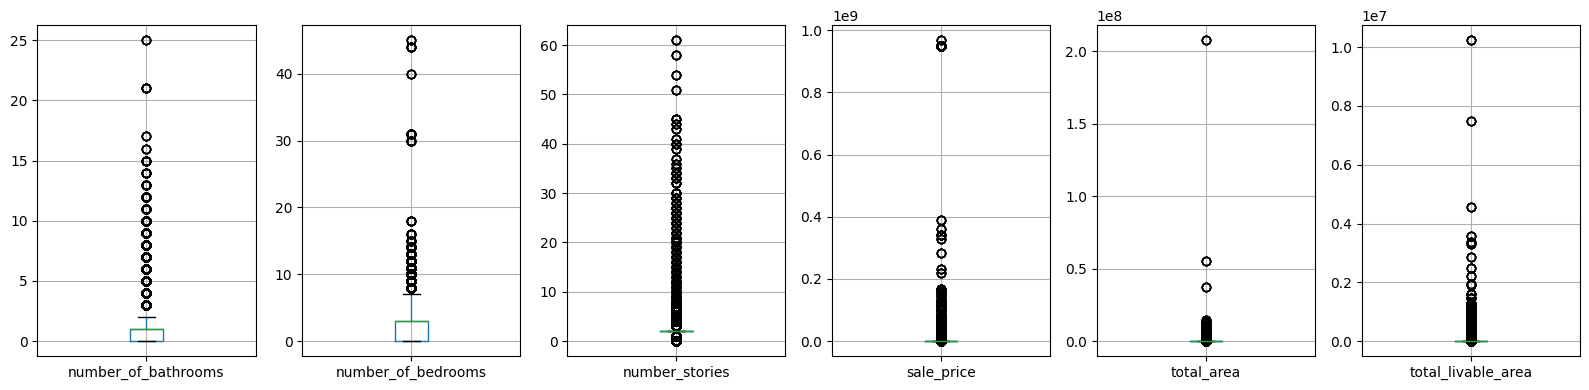

In [68]:
# Property df boxplots
columns_for_boxplots = ['number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 'sale_price', 'total_area', 'total_livable_area']

# set figure and axis
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
# iterate through all columns and add to figure
for col in columns_for_boxplots:
    rea_final.boxplot(column=col, ax= ax[i]) 
    i += 1

# display plot    
plt.tight_layout()
plt.show() 

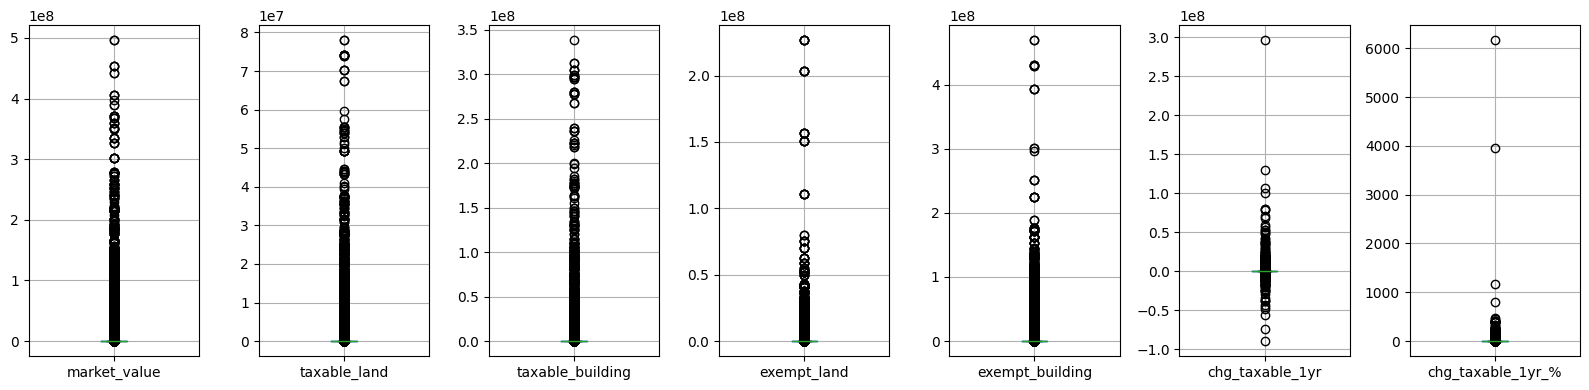

In [69]:
# Assessments boxplots
columns_for_boxplots = ['market_value','taxable_land','taxable_building','exempt_land','exempt_building', 'chg_taxable_1yr', 'chg_taxable_1yr_%']

# set figure and axis
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
# iterate through all columns and add to figure
for col in columns_for_boxplots:
    rea_final.boxplot(column=col, ax= ax[i])
    i += 1

# display plot
plt.tight_layout()
plt.show() 

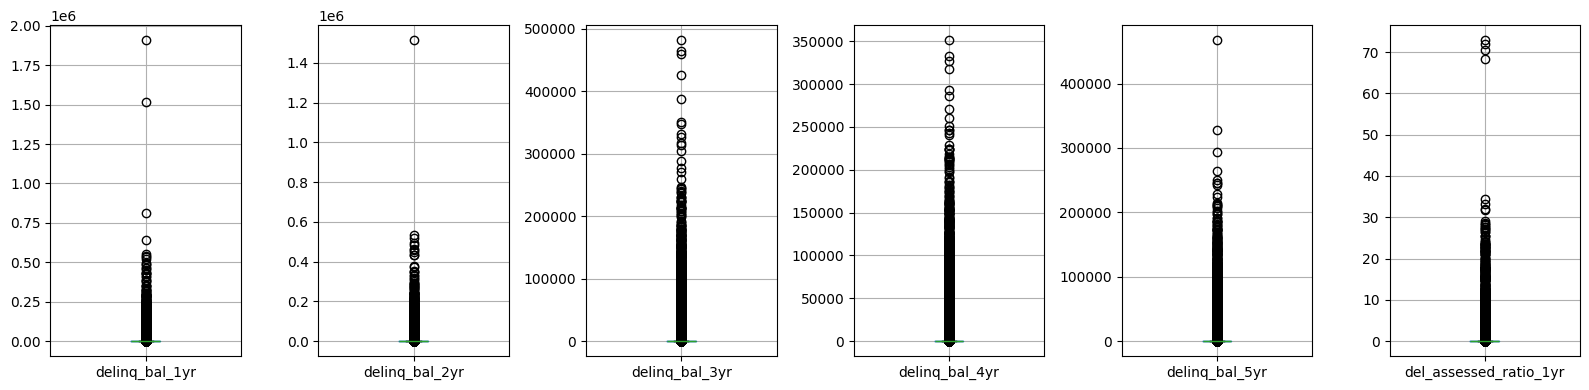

In [70]:
# Delinquency boxplots
columns_for_boxplots = ['delinq_bal_1yr','delinq_bal_2yr','delinq_bal_3yr','delinq_bal_4yr','delinq_bal_5yr', 'del_assessed_ratio_1yr']

# set figure and axis
fig, ax = plt.subplots(nrows= 1, ncols= len(columns_for_boxplots), figsize= (16, 4))

i = 0
# iterate through all columns and add to figure
for col in columns_for_boxplots:
    rea_final.boxplot(column=col, ax= ax[i])
    i += 1

# display plots    
plt.tight_layout()
plt.show() 

## Examine skewness

In [71]:
rea_final[['number_of_bathrooms', 'number_of_bedrooms', 'number_stories', 'sale_price', 'total_area', 'total_livable_area']].skew()

number_of_bathrooms      1.656450
number_of_bedrooms       0.147634
number_stories           6.132042
sale_price              92.257113
total_area             612.153365
total_livable_area     187.726734
dtype: float64

In [72]:
rea_final[['market_value','taxable_land','taxable_building','exempt_land','exempt_building','chg_taxable_1yr', 'chg_taxable_1yr_%']].skew()

market_value           69.420919
taxable_land           78.078639
taxable_building      114.372886
exempt_land           182.411024
exempt_building       103.289653
chg_taxable_1yr       380.310534
chg_taxable_1yr_%    1002.206836
dtype: float64

In [73]:
rea_final[['delinq_bal_1yr','delinq_bal_2yr','delinq_bal_3yr','delinq_bal_4yr','delinq_bal_5yr', 'del_assessed_ratio_1yr']].skew()

delinq_bal_1yr            71.321244
delinq_bal_2yr            43.486821
delinq_bal_3yr            20.773959
delinq_bal_4yr            18.104598
delinq_bal_5yr            17.978346
del_assessed_ratio_1yr    69.746245
dtype: float64

## Correlation Analysis

In [74]:
# create correlation matrix
corr_matrix = rea_final[['market_value', 'taxable_land','taxable_building', 'exempt_land', 'exempt_building', 'taxable','exempt', 'taxable_1yr', 'exempt_1yr', 'taxable_3yr', 'exempt_3yr',
       'taxable_5yr', 'exempt_5yr', 'exterior_condition', 'interior_condition','homestead_exemption', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_stories', 'sale_date', 'sale_price', 'total_area', 'total_livable_area', 'year_built', 'condo', 'delinq_bal_1yr',
       'delinq_bal_2yr', 'delinq_bal_3yr', 'delinq_bal_4yr', 'delinq_bal_5yr','chg_taxable_1yr','chg_taxable_1yr_%', 'chg_taxable_3yr', 'chg_taxable_3yr_%',
       'chg_taxable_5yr', 'chg_taxable_5yr_%', 'taxable_%', 'delinq','delinq_1yr','delinq_2yr', 'delinq_3yr', 'delinq_4yr', 'delinq_5yr', 'years_delinq',
       'del_assessed_ratio_1yr']].corr()

<Axes: >

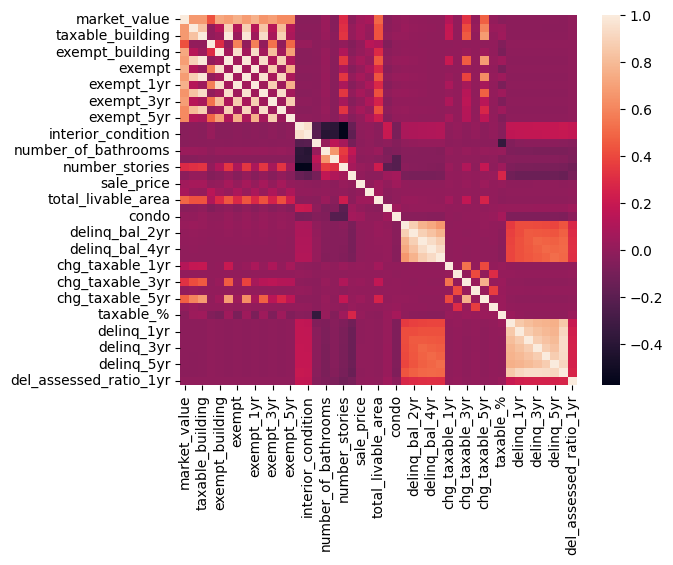

In [75]:
# create correlation heat map
sns.heatmap(corr_matrix)

# Data Exploration

In [76]:
# number of parcels examined
rea_final.parcel_number.unique().shape

(572257,)

[Text(0.5, 0, 'Delinquent Properties'), Text(0, 0.5, 'Year')]

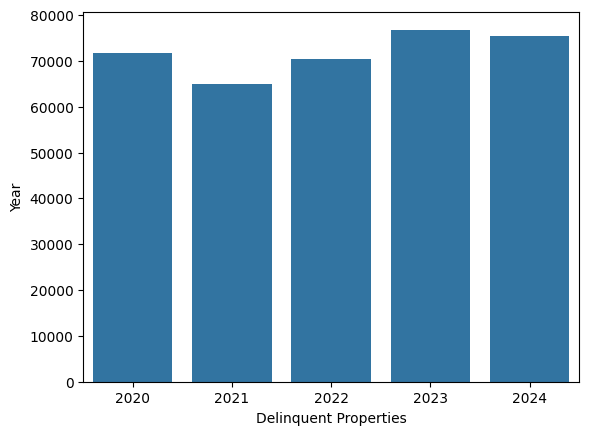

In [ ]:
# create df with delinquency counts by year
rea_bar = pd.DataFrame(rea_final.groupby('year')['delinq'].sum())

# create bar plot                     
sns.barplot(rea_bar, x ="year", y="delinq").set(xlabel="Delinquent Properties", ylabel="Year")

In [ ]:
# create df with delinquency counts by year
rea_bar[] = pd.DataFrame(rea_final.groupby('year')['delinq'].sum())

# create bar plot                     
sns.barplot(rea_bar, x ="year", y="delinq").set(xlabel="Delinquent Properties", ylabel="Year")